# COGS 108 - Final Project Proposal

# Overview

This paper focuses on finding out some potential confounding variables that affect the rate of car collisions in San Diego, and throughout the report we analyzed datasets of Amazon Quarterly Revenue and Monthly rainfall in SD. After combining all of our data, and exhausting various tests for possible correlation, we ran several linear regression tests and a multivariate regression test, to ultimately find out that Amazon's Quarterly Revenue was the strongest predictor for car accidents in San Diego.

# Names

- Jason Ho
- Eric Ngo
- Nathan Nguyen
- Jeffrey Wu

# Research Question

Can the number of car accidents in San Diego be attributed to the rise of Amazon sales/revenue during the holiday season?

## Background and Prior Work

&emsp; This question interested us because we are all frequent Amazon customers and always know that the holiday season is the best time to shop for gifts. With that in mind, we considered the actual labor that goes into getting a product delivered to our doorstep and considered the question of whether or not a spike in sales for Amazon had any effect on the number of car accidents in that given time period. We were also curious if there were other cofounding factors that resulted in car crashes (4), so we also found a data set of annual rainfall within San Diego (3). Based on these factors, we hypothesized that there is a positive correlation between increased Amazon holiday season sales and the number of car accidents within San Diego. However, the number of car accidents is more so strongly attributed to drunk driving/rainfall.

&emsp; We know that there will be a casual relationship between Amazon quarterly revenues and car collisions, but we find this interesting because we want to know how strongly/weakly each dataset affects each other. We also wanted to know how these results would change if they were within San Diego.

&emsp; When looking at ycharts (1), we noticed that Amazon revenue peaked right before Christmas each year and for most of the other significant holidays. The importance of this is that there will be a significant increase in the number of deliveries from Amazon. We’re curious to see if the increase in deliveries will affect the number of car accidents during holidays.
   
&emsp; There is already a publication on estimates of motor vehicle traffic crash fatalities for the holiday periods of 2019 (2), by the National Highway Traffic Safety Administration that we can utilize for our analysis. We noticed in "Traffic Accidents in Los Angeles EDA" (4) that there were spikes of accidents during months where major holidays were celebrated .


References: <br>
(1) Amazon.com Quarterly Revenue <br>
https://ycharts.com/companies/AMZN/revenues <br>
(2) “Estimates of Motor Vehicle Traffic Crash Fatalities for the Holiday Periods of 2019” <br>
https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812823 <br>
(3) San Diego Annual Rain Fall <br>
https://www.custompuzzlecraft.com/Weather/sandiegorain.html <br>
(4) Traffic Accidents in Los Angeles EDA <br>
https://www.kaggle.com/natevegh/traffic-accidents-in-los-angeles-eda

# Hypothesis


&emsp; There is a positive correlation between increased Amazon holiday season sales and the number of car accidents within San Diego. However, the number of car accidents is more so strongly attributed to drunk driving/rainfall because we think physical conditions will increase the likelihood of collisions.


# Dataset(s)

### Amazon Quarterly Revenue

- Dataset Name: Amazon Quarterly Revenue
- Link to the website containing dataset: https://ycharts.com/companies/AMZN/revenues Scraped data, code included in repo
- Features: ['quarter', 'revenue']
- Number of observations: 50

This dataset contains the revenue from each business quarter in the year from March 2020 back to December 2007. The quarterly revenue is measured in billions.

### San Diego Traffic Collisions

- Dataset Name: San Diego Traffic Collision
- Link to the dataset: https://data.sandiego.gov/datasets/police-collisions/
- Features: ['report_id', 'date_time', 'police_beat', 'address_number_primary', 'address_pd_primary', 'address_road_primary', 'address_sfx_primary', 'address_pd_intersecting', 'address_name_intersecting', 'address_sfx_intersecting', 'violation_section', 'violation_type', 'charge_desc', 'injured', 'killed', 'hit_run_lvl']
- Number of observations: 22368

This dataset is a list of traffic collision reports in San Diego from 2015-2020. It consists of the time, date, and description of the charge.

### San Diego Annual Rain Fall

- Dataset Name: San Diego Annual Rain Fall
- Link to the dataset: https://www.custompuzzlecraft.com/Weather/sandiegorain.html
- Features: ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'YearTotal', 'NextJan', 'NextFeb', 'NextMar', 'NextApr', 'NextMay', 'NextJun', 'SeasonTotal']
- Number of observations: 171

This dataset contains a record of the annual rainfall in San Diego from 1850-2020, and the rainfall is recorded in inches. 

# Setup


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import statsmodels.api as sm

# Data Cleaning

The functions below are used to standardize the datasets that we are working with.

In [2]:
# Categorizing months of collisions into corresponding quarters
def identify_quarter_collisions(date):
    month = date[5:6+1]
    if (month=='04') or (month=='05') or (month=='06'):
        return 2
    elif (month=='07') or (month=='08') or (month=='09'):
        return 3
    elif (month=='10') or (month=='11') or (month=='12'):
        return 4
    elif (month=='01') or (month=='02') or (month=='03'):
        return 1
    else:
        return month

# Converts years into type integer
def identify_year_collisions(date):
    year = date[0:4]
    if(year == '2018'):
        return 2018
    elif(year == '2019'):
        return 2019
    elif(year == '2020'):
        return 2020
    else:
        return ''

# Converts from months to quarter
def convert_amazon(row):
    if 'Mar' in row:
        return 1
    elif 'Dec' in row:
        return 4
    elif 'Sep' in row:
        return 3
    elif 'Jun' in row:
        return 2

# Extracts the year from the date given
def extract_year_amazon(row):
    return row[-4:]

### Amazon Quarterly Revenue Data
We then read in our csv file for Amazon quarterly revenue

In [3]:
amazon_df = pd.read_csv('amazon_quarterly_revenue.csv')
amazon_df = amazon_df.drop('Unnamed: 0', axis=1)

In [4]:
amazon_df.head()

,quarter,revenue
0,"March 31, 2020",75.45B
1,"Dec. 31, 2019",87.44B
2,"Sept. 30, 2019",69.98B
3,"June 30, 2019",63.40B
4,"March 31, 2019",59.70B


In [5]:
amazon_df.shape

(50, 2)

In [6]:
amazon_df.columns

Index(['quarter', 'revenue'], dtype='object')

The 'quarter' column had both the month and year for each observation. We made a 'Quarter' column and standardized it. We also extracted the year for each observation and input them into a new 'Year' column.

In [7]:
amazon_df['Quarter'] = amazon_df['quarter'].apply(convert_amazon)
amazon_df['Year'] = amazon_df['quarter'].apply(extract_year_amazon)
amazon_df = amazon_df[(amazon_df['Year'] == str(2018)) | (amazon_df['Year'] == str(2019)) | (amazon_df['Year'] == str(2020))]
amazon_df['Year'] = pd.to_numeric(amazon_df.Year, errors='coerce')
amazon_df = amazon_df[['revenue', 'Quarter', 'Year']]
amazon_df = amazon_df.rename({'Quarter': 'quarter', 'Year': 'year'}, axis='columns')
amazon_df = amazon_df[['quarter', 'year', 'revenue']]
amazon_df.head()

,quarter,year,revenue
0,1,2020,75.45B
1,4,2019,87.44B
2,3,2019,69.98B
3,2,2019,63.40B
4,1,2019,59.70B


### Vehicle Collisions Data
Next, we read in the csv file for our collisions dataset.

In [8]:
collisions_df = pd.read_csv('pd_collisions_datasd_v1.csv')

In [10]:
collisions_df.head()

,report_id,date_time,police_beat,address_number_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
0,180282,2018-01-01 00:30:00,124,6500,,EL CAMINO DE TEATRO,,,,,22350,VC,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...,0,0,NaN
1,180310,2018-01-01 01:00:00,616,500,,ROSECRANS,STREET,,,,22350,VC,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...,0,0,MISDEMEANOR
2,180573,2018-01-01 01:26:00,721,0,,PALM,AVENUE,,18TH,STREET,21954A,VC,PEDESTRIANS OUTSIDE CROSSWALKS,0,1,NaN
3,180317,2018-01-01 02:05:00,512,3100,,LOGAN,AVENUE,,,,22450(A),VC,STOP REQUIREMENTS STATE STOP LINE,0,0,MISDEMEANOR
4,180319,2018-01-01 02:26:00,439,6200,,DIVISION,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR


Now that we can see our dataset, we want to observe the unique values of charge descriptions in order to see how many violations actually included drunk driving

In [12]:
collisions_df['charge_desc'].unique()

array(['VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR CONDITIONS',
       'PEDESTRIANS OUTSIDE CROSSWALKS',
       'STOP REQUIREMENTS STATE STOP LINE',
       'TURNING MOVEMENTS AND REQUIRED SIGNALS',
       'RED OR STOPVEHICLES STOP AT LIMIT LINE',
       'MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHICLE CODE',
       'OBEDIENCE TO OFFICIAL TRAFFIC CONTROL',
       'FAILURE TO DRIVE ON RIGHT SIDE OF ROADWAY', 'DUI DRUGS',
       'RED ARROWDO NOT ENTER INTERSECTION', 'FOLLOWING TOO CLOSELY (I)',
       'FOLLOWING TOO CLOSELY', 'PASS ON THE RIGHT SAFELY',
       'YIELD RIGHT OF WAY TO PEDESTRIANS',
       'YIELD RIGHT OF WAY TO EMERGENCY VEHICLE',
       'STARTING PARKED VEHICLES OR BACKING',
       'LEFT TURN YIELD UNTIL SAFE OR U-TURN',
       'BICYCLE DRIVING ON WRONG SIDE OF ROAD',
       'ENTERING HWY FROM PRIVATE ROAD OR DRIVEWAY',
       'PARKING BRAKE SYSTEM', 'HIT AND RUN',
       'USE OF CELL PHONE W/O HANDS FREE DEVICE WHILE DRIVING',
       'ENTRANCE FROM STOP THROUGH HIGHW

In [13]:
collisions_df.shape

(22368, 16)

In [14]:
collisions_df.columns

Index(['report_id', 'date_time', 'police_beat', 'address_number_primary',
       'address_pd_primary', 'address_road_primary', 'address_sfx_primary',
       'address_pd_intersecting', 'address_name_intersecting',
       'address_sfx_intersecting', 'violation_section', 'violation_type',
       'charge_desc', 'injured', 'killed', 'hit_run_lvl'],
      dtype='object')

The month was taken from the 'date_time' column and standardized into quarters in a new column. The year was also extracted from 'date_time' and input into a new 'year' column. 

In [15]:
collisions_df['Quarter'] = collisions_df['date_time'].apply(identify_quarter_collisions)
collisions_df['Year'] = collisions_df['date_time'].apply(identify_year_collisions)    

In [16]:
collisions_df = collisions_df[['date_time', 'charge_desc']]
collisions_df['Quarter'] = collisions_df['date_time'].apply(identify_quarter_collisions)
collisions_df['Year'] =  collisions_df['date_time'].apply(identify_year_collisions)
collisions_df.head()

,date_time,charge_desc,Quarter,Year
0,2018-01-01 00:30:00,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...,1,2018
1,2018-01-01 01:00:00,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...,1,2018
2,2018-01-01 01:26:00,PEDESTRIANS OUTSIDE CROSSWALKS,1,2018
3,2018-01-01 02:05:00,STOP REQUIREMENTS STATE STOP LINE,1,2018
4,2018-01-01 02:26:00,TURNING MOVEMENTS AND REQUIRED SIGNALS,1,2018


We created two functions to convert months to their corresponding numbers and vice versa so functions could sort by least to highest. The first method retrieves the month from the time stamp.

In [17]:
#Convert month number to name
def standardize_date_time(date):
    month = date[5:6+1]
    if month == '01':
        return 'Jan'
    elif month == '02':
        return 'Feb'
    elif month == '03':
        return 'Mar'
    elif month == '04':
        return 'Apr'
    elif month == '05':
        return 'May'
    elif month == '06':
        return 'Jun'
    elif month == '07':
        return 'Jul'
    elif month == '08':
        return 'Aug'
    elif month == '09':
        return 'Sep'
    elif month == '10':
        return 'Oct'
    elif month == '11':
        return 'Nov'
    elif month == '12':
        return 'Dec'
    else:
        return month

#Convert month to corresponding number
def month_to_num(month):
    if month == 'Jan':
        return 1
    elif month == 'Feb':
        return 2
    elif month == 'Mar':
        return 3
    elif month == 'Apr':
        return 4
    elif month == 'May':
        return 5
    elif month == 'Jun':
        return 6
    elif month == 'Jul':
        return 7
    elif month == 'Aug':
        return 8
    elif month == 'Sep':
        return 9
    elif month == 'Oct':
        return 10
    elif month == 'Nov':
        return 11
    elif month == 'Dec':
        return 12
    else:
        return 0
#Convert number to corresponding month    
def num_to_month(month):

    if month == 1:
        return 'Jan'
    elif month == 2:
        return 'Feb'
    elif month == 3:
        return 'Mar'
    elif month == 4:
        return 'Apr'
    elif month == 5:
        return 'May'
    elif month == 6:
        return 'Jun'
    elif month == 7:
        return 'Jul'
    elif month == 8:
        return 'Aug'
    elif month == 9:
        return 'Sep'
    elif month == 10:
        return 'Oct'
    elif month == 11:
        return 'Nov'
    elif month == 12:
        return 'Dec'
    else:
        return month    

# Converts from months to quarter for rain data
def month_to_year_rain(month):
    if (month=='Jan') or (month=='Feb') or (month=='Mar'):
        return 1
    elif (month=='Apr') or (month=='May') or (month=='Jun'):
        return 2
    elif (month=='Jul') or (month=='Aug') or (month=='Sep'):
        return 3
    elif (month=='Oct') or (month=='Nov') or (month=='Dec'):
        return 4


Next we want to standardize the column names and the structure of the collision dataframe so that it shares similar columns as the amazon revenue dataframe and the rainfall dataframe (ex. 'quarter', 'year', etc. )

In [18]:
std_collisions_df = collisions_df.rename({'date_time': 'month'}, axis='columns')
std_collisions_df['month'] = std_collisions_df['month'].apply(standardize_date_time)
std_collisions_df = std_collisions_df[['Quarter', 'Year', 'month', 'charge_desc']]
std_collisions_df = std_collisions_df.rename(columns = {'Quarter': 'quarter', 'Year': 'year'})

In [19]:
std_collisions_df

,quarter,year,month,charge_desc
0,1,2018,Jan,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...
1,1,2018,Jan,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...
2,1,2018,Jan,PEDESTRIANS OUTSIDE CROSSWALKS
3,1,2018,Jan,STOP REQUIREMENTS STATE STOP LINE
4,1,2018,Jan,TURNING MOVEMENTS AND REQUIRED SIGNALS
...,...,...,...,...
22363,2,2020,Apr,UNSAFE SPEED (BASIC SPEED LAW) (I)
22364,2,2020,Apr,JAYWALKING (I)
22365,2,2020,Apr,TURNS:UNSAFE TURN AND/OR NO TURN SIGNAL (I)
22366,2,2020,Apr,THREE FEET FOR SAFETY ACT (I)


### Rainfall Data
Now we read in our csv for rainfall

In [20]:
rain_df = pd.read_csv('sd_rain_data.txt', header=None, index_col=0)

In [21]:
rain_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
1850,0.00,1.13,1.00,0.09,0.00,0.68,0.00,0.00,0.00,0.19,2.82,1.93,7.84,0.03,1.51,0.34,0.87,0.71,0.01,8.41
1851,0.03,1.51,0.34,0.87,0.71,0.01,0.00,0.00,0.02,0.01,0.25,3.74,7.49,0.58,1.84,1.87,0.85,0.32,0.00,9.48
1852,0.58,1.84,1.87,0.85,0.32,0.00,0.00,0.40,0.00,0.06,1.45,4.50,11.87,0.50,0.20,1.52,0.25,2.10,0.05,11.03
1853,0.50,0.20,1.52,0.25,2.10,0.05,0.00,0.21,0.00,0.00,1.28,1.77,7.88,0.99,2.56,1.88,0.89,0.18,0.01,9.77
1854,0.99,2.56,1.88,0.89,0.18,0.01,0.07,1.36,0.09,0.27,0.04,3.29,11.63,1.97,3.59,1.30,1.52,0.06,0.00,13.56


In [22]:
rain_df.shape

(171, 20)

In [23]:
rain_df.columns =  ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'YearTotal', 'NextJan', 'NextFeb', 'NextMar', 'NextApr', 'NextMay', 'NextJun', 'SeasonTotal']

In [24]:
rain_df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YearTotal,NextJan,NextFeb,NextMar,NextApr,NextMay,NextJun,SeasonTotal
0,,,,,,,,,,,,,,,,,,,,
1850,0.00,1.13,1.00,0.09,0.00,0.68,0.00,0.00,0.00,0.19,2.82,1.93,7.84,0.03,1.51,0.34,0.87,0.71,0.01,8.41
1851,0.03,1.51,0.34,0.87,0.71,0.01,0.00,0.00,0.02,0.01,0.25,3.74,7.49,0.58,1.84,1.87,0.85,0.32,0.00,9.48
1852,0.58,1.84,1.87,0.85,0.32,0.00,0.00,0.40,0.00,0.06,1.45,4.50,11.87,0.50,0.20,1.52,0.25,2.10,0.05,11.03
1853,0.50,0.20,1.52,0.25,2.10,0.05,0.00,0.21,0.00,0.00,1.28,1.77,7.88,0.99,2.56,1.88,0.89,0.18,0.01,9.77
1854,0.99,2.56,1.88,0.89,0.18,0.01,0.07,1.36,0.09,0.27,0.04,3.29,11.63,1.97,3.59,1.30,1.52,0.06,0.00,13.56


Just like the collisions dataframe above, we structure our rainfall dataframe so that the columns are similar to the amazon revenue dataframe and the collisions dataframe.

In [25]:
rain_df = rain_df[rain_df.index>=2018]
rain_df = rain_df.iloc[:, 0:12]
amount_rainfall = list(rain_df.iloc[0,:].values)+list(rain_df.iloc[1,:].values)+list(rain_df.iloc[2,:].values)
year_rain = [2018]*12+[2019]*12+[2020]*12
months_rain = list(rain_df.columns)*3
new_rain_df = pd.DataFrame({'year':year_rain,'month':months_rain,'amount_rainfall':amount_rainfall})
new_rain_df['quarter'] = new_rain_df['month'].apply(month_to_year_rain)
new_rain_df = new_rain_df[['quarter','year','month','amount_rainfall']]

In [26]:
new_rain_df.head()

,quarter,year,month,amount_rainfall
0,1,2018,Jan,1.78
1,1,2018,Feb,0.36
2,1,2018,Mar,0.95
3,2,2018,Apr,0.02
4,2,2018,May,0.12


### Merging

We created a method to retrieve revenue values based on quarter and year. We also checked for descriptions that were considered 'DUI' or 'Other Violation'

In [1]:
def quarter_year_revenue(Quarter,Year):
    if (Quarter==1) and (Year==2020):
        return 75.45
    elif (Quarter==4) and (Year==2019):
        return 87.44
    elif (Quarter==3) and (Year==2019):
        return 69.98
    elif (Quarter==2) and (Year==2019):
        return 63.40
    elif (Quarter==1) and (Year==2019):
        return 59.70
    elif (Quarter==4) and (Year==2018):
        return 72.38
    elif (Quarter==3) and (Year==2018):
        return 56.58
    elif (Quarter==2) and (Year==2018):
        return 52.89
    elif (Quarter==1) and (Year==2018):
        return 51.04
    else:
        return 0

#Look for descriptions involving DUI
def is_dui(desc):
    if 'DUI' in desc or 'ALC' in desc or 'DRUGS' in desc or 'DRUG' in desc or 'Narcotic' in desc:
        return 'DUI'
    else:
        return 'Other Violation'

Here we collect the number of collision counts per month in our dataset

In [28]:
std_collisions_df['month'] = std_collisions_df['month'].apply(month_to_num)
month_year_collisions = std_collisions_df.groupby(['month', 'year']).charge_desc.size().values

Here we collect the number of DUI specific collisions per month in our dataset

In [29]:
std_collisions_df['charge_desc'] = std_collisions_df['charge_desc'].apply(is_dui)
month_year_dui = std_collisions_df[std_collisions_df['charge_desc'] == 'DUI'].groupby(['month', 'year']).charge_desc.size().values

In [30]:
month_year_collisions

array([761, 808, 769, 726, 756, 781, 851, 871, 544, 733, 816, 266, 801,
       811, 866, 850, 865, 896, 823, 859, 840, 908, 882, 911, 871, 824,
       887, 792])

In [31]:
month_year_dui

array([ 6,  5, 44,  2,  7, 56,  7, 17, 31,  1, 27, 21,  5, 28, 12, 37,  6,
       43,  2, 42,  8, 41,  3, 55,  3, 46, 11, 46])

In [32]:
std_collisions_df['month'] = std_collisions_df['month'].apply(num_to_month)

These methods return the collision counts and DUI counts corresponding to the month and year.

In [33]:
def month_year_collisioncounts(Month, Year):

    if (Month=='Jan'):
        if (Year==2018):
            return month_year_collisions[0]
        elif (Year==2019):
            return month_year_collisions[1]
        else:
            return month_year_collisions[2]
    elif Month == 'Feb':
        if (Year==2018):
            return month_year_collisions[3]
        elif (Year==2019):
            return month_year_collisions[4]
        else:
            return month_year_collisions[5]
    elif Month == 'Mar':
        if (Year==2018):
            return month_year_collisions[6]
        elif (Year==2019):
            return month_year_collisions[7]
        else:
            return month_year_collisions[8]
    elif Month == 'Apr':
        if (Year==2018):
            return month_year_collisions[9]
        elif (Year==2019):
            return month_year_collisions[10]
        else:
            return month_year_collisions[11]
    elif Month == 'May':
        if (Year==2018):
            return month_year_collisions[12]
        elif (Year==2019):
            return month_year_collisions[13]
        else:
            return 0
    elif Month == 'Jun':
        if (Year==2018):
            return month_year_collisions[14]
        elif (Year==2019):
            return month_year_collisions[15]
        else:
            return 0
    elif Month == 'Jul':
        if (Year==2018):
            return month_year_collisions[16]
        elif (Year==2019):
            return month_year_collisions[17]
        else:
            return 0
    elif Month == 'Aug':
        if (Year==2018):
            return month_year_collisions[18]
        elif (Year==2019):
            return month_year_collisions[19]
        else:
            return 0
    elif Month == 'Sep':
        if (Year==2018):
            return month_year_collisions[20]
        elif (Year==2019):
            return month_year_collisions[21]
        else:
            return 0
    elif Month == 'Oct':
        if (Year==2018):
            return month_year_collisions[22]
        elif (Year==2019):
            return month_year_collisions[23]
        else:
            return 0
    elif Month == 'Nov':
        if (Year==2018):
            return month_year_collisions[24]
        elif (Year==2019):
            return month_year_collisions[25]
        else:
            return 0
    elif Month == 'Dec':
        if (Year==2018):
            return month_year_collisions[26]
        elif (Year==2019):
            return month_year_collisions[27]
        else:
            return 0
    else:
        return 0

def month_year_duicounts(Month, Year):
    if (Month=='Jan'):
        if (Year==2018):
            return month_year_dui[0]
        elif (Year==2019):
            return month_year_dui[1]
        else:
            return month_year_dui[2]
    elif Month == 'Feb':
        if (Year==2018):
            return month_year_dui[3]
        elif (Year==2019):
            return month_year_dui[4]
        else:
            return month_year_dui[5]
    elif Month == 'Mar':
        if (Year==2018):
            return month_year_dui[6]
        elif (Year==2019):
            return month_year_dui[7]
        else:
            return month_year_dui[8]
    elif Month == 'Apr':
        if (Year==2018):
            return month_year_dui[9]
        elif (Year==2019):
            return month_year_dui[10]
        else:
            return month_year_dui[11]
    elif Month == 'May':
        if (Year==2018):
            return month_year_dui[12]
        elif (Year==2019):
            return month_year_dui[13]
        else:
            return 0
    elif Month == 'Jun':
        if (Year==2018):
            return month_year_dui[14]
        elif (Year==2019):
            return month_year_dui[15]
        else:
            return 0
    elif Month == 'Jul':
        if (Year==2018):
            return month_year_dui[16]
        elif (Year==2019):
            return month_year_dui[17]
        else:
            return 0
    elif Month == 'Aug':
        if (Year==2018):
            return month_year_dui[18]
        elif (Year==2019):
            return month_year_dui[19]
        else:
            return 0
    elif Month == 'Sep':
        if (Year==2018):
            return month_year_dui[20]
        elif (Year==2019):
            return month_year_dui[21]
        else:
            return 0
    elif Month == 'Oct':
        if (Year==2018):
            return month_year_dui[22]
        elif (Year==2019):
            return month_year_dui[23]
        else:
            return 0
    elif Month == 'Nov':
        if (Year==2018):
            return month_year_dui[24]
        elif (Year==2019):
            return month_year_dui[25]
        else:
            return 0
    elif Month == 'Dec':
        if (Year==2018):
            return month_year_dui[26]
        elif (Year==2019):
            return month_year_dui[27]
        else:
            return 0
    else:
        return 0


In [34]:
std_collisions_df['collision_counts'] = std_collisions_df.apply(lambda x: month_year_collisioncounts(x['month'], x['year']), axis=1)
std_collisions_df['dui_counts'] = std_collisions_df.apply(lambda x: month_year_duicounts(x['month'], x['year']), axis=1)

In [35]:
std_collisions_df.head()

,quarter,year,month,charge_desc,collision_counts,dui_counts
0,1,2018,Jan,Other Violation,761,6
1,1,2018,Jan,Other Violation,761,6
2,1,2018,Jan,Other Violation,761,6
3,1,2018,Jan,Other Violation,761,6
4,1,2018,Jan,Other Violation,761,6


We start merging by year and quarter

In [36]:
amazon_df['g']=amazon_df.groupby(['year','quarter']).cumcount()
std_collisions_df['g']=std_collisions_df.groupby(['year','quarter']).cumcount()
new_df = std_collisions_df.merge(amazon_df,how='left').drop('g',1)
new_df['revenue'] = new_df.apply(lambda x: quarter_year_revenue(x['quarter'], x['year']), axis=1)

In [37]:
new_df.head()

,quarter,year,month,charge_desc,collision_counts,dui_counts,revenue
0,1,2018,Jan,Other Violation,761,6,51.04
1,1,2018,Jan,Other Violation,761,6,51.04
2,1,2018,Jan,Other Violation,761,6,51.04
3,1,2018,Jan,Other Violation,761,6,51.04
4,1,2018,Jan,Other Violation,761,6,51.04


Merge current set with our rain dataframe based on month, year, and quarter.

In [38]:
new_df = pd.merge(new_df, new_rain_df, on=['month', 'year', 'quarter'])

In [39]:
new_df.head()

,quarter,year,month,charge_desc,collision_counts,dui_counts,revenue,amount_rainfall
0,1,2018,Jan,Other Violation,761,6,51.04,1.78
1,1,2018,Jan,Other Violation,761,6,51.04,1.78
2,1,2018,Jan,Other Violation,761,6,51.04,1.78
3,1,2018,Jan,Other Violation,761,6,51.04,1.78
4,1,2018,Jan,Other Violation,761,6,51.04,1.78


Now that all dataframes are merged together, we can check to see how one variable can potentially affect the other

# Data Analysis & Results

In [40]:
new_df.describe() #General Overview Stats

,quarter,year,collision_counts,dui_counts,revenue,amount_rainfall
count,22368.000000,22368.000000,22368.000000,22368.000000,22368.000000,22368.000000
mean,2.387071,2018.662643,818.677843,22.009254,64.740083,0.959164
std,1.145996,0.659229,90.582666,18.612492,13.196031,1.233496
min,1.000000,2018.000000,266.000000,1.000000,0.000000,0.000000
25%,1.000000,2018.000000,792.000000,5.000000,56.580000,0.010000
50%,2.000000,2019.000000,840.000000,12.000000,63.400000,0.380000
75%,3.000000,2019.000000,871.000000,42.000000,72.380000,1.780000
max,4.000000,2020.000000,911.000000,56.000000,87.440000,4.030000


### Correlation Of Features

From this correlation matrix, we observed that no two features are highly correlated with each other. Revenue has a 0.12 correlation value with amount_rainfall and a 0.64 correlation value with dui_counts. dui_counts has a -0.025 correlation value with amount_rainfall. This means that our data is not multicollinear.

(4.0, 0.0)

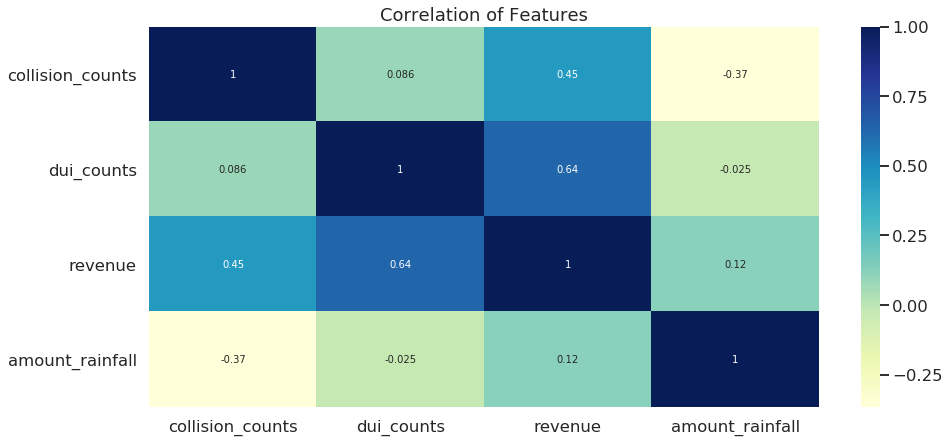

In [41]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Correlation of Features')
ax = sns.heatmap(new_df.drop(['quarter', 'year', 'month'], axis=1).corr(), cmap="YlGnBu", annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Pairplot Between Features

This pairplot helps us visualize linear relationships between features. The highest correlation is between revenue and dui_counts which has a clear linear relationship within the pairplot. Revenue and rainfall also has a clear linear relationship. 

Text(0.5, 1.08, 'Pairplot of Features')

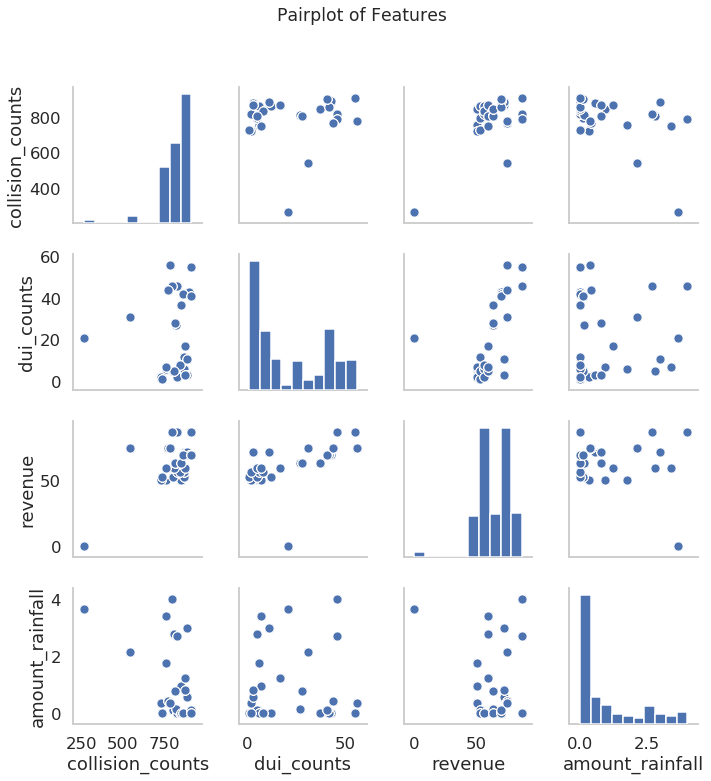

In [42]:
sns.set_style("whitegrid", {'axes.grid' : False})
g = sns.pairplot(new_df.drop(['quarter', 'year', 'month'], axis=1))
g.fig.suptitle("Pairplot of Features", y=1.08, fontsize='xx-large')

### Amazon Revenue and Collisions Count Plot / Analysis

In [43]:
new_df.groupby(['month', 'year']).revenue.describe() #Overview of Stats over Month and Year

count   mean           std    min    25%    50%    75%    max
month year                                                               
Apr   2018  733.0  52.89  7.110279e-15  52.89  52.89  52.89  52.89  52.89
      2019  816.0  63.40  1.421957e-14  63.40  63.40  63.40  63.40  63.40
      2020  266.0   0.00  0.000000e+00   0.00   0.00   0.00   0.00   0.00
Aug   2018  823.0  56.58  0.000000e+00  56.58  56.58  56.58  56.58  56.58
      2019  859.0  69.98  0.000000e+00  69.98  69.98  69.98  69.98  69.98
Dec   2018  887.0  72.38  0.000000e+00  72.38  72.38  72.38  72.38  72.38
      2019  792.0  87.44  1.421983e-14  87.44  87.44  87.44  87.44  87.44
Feb   2018  726.0  51.04  0.000000e+00  51.04  51.04  51.04  51.04  51.04
      2019  756.0  59.70  0.000000e+00  59.70  59.70  59.70  59.70  59.70
      2020  781.0  75.45  1.421996e-14  75.45  75.45  75.45  75.45  75.45
Jan   2018  761.0  51.04  7.110100e-15  51.04  51.04  51.04  51.04  51.04
      2019  808.0  59.70  7.109828e-15  59.70  59.70  59.70  59.70  59.70
      2020  769.0  75.45  1.422010e-14  75.45  75.45  75.45  75.45  75.45
Jul   2018  865.0  56.58  1.421908e-14  56.58  56.58  56.58  56.58  56.58
      2019  896.0  69.98  0.000000e+00  69.98  69.98  69.98  69.98  69.98
Jun   2018  866.0  52.89  1.421907e-14  52.89  52.89  52.89  52.89  52.89
      2019  850.0  63.40  1.421922e-14  63.40  63.40  63.40  63.40  63.40
Mar   2018  851.0  51.04  7.109606e-15  51.04  51.04  51.04  51.04  51.04
      2019  871.0  59.70  7.109510e-15  59.70  59.70  59.70  59.70  59.70
      2020  544.0  75.45  0.000000e+00  75.45  75.45  75.45  75.45  75.45
May   2018  801.0  52.89  0.000000e+00  52.89  52.89  52.89  52.89  52.89
      2019  811.0  63.40  1.421962e-14  63.40  63.40  63.40  63.40  63.40
Nov   2018  871.0  72.38  1.421902e-14  72.38  72.38  72.38  72.38  72.38
      2019  824.0  87.44  1.421949e-14  87.44  87.44  87.44  87.44  87.44
Oct   2018  882.0  72.38  0.000000e+00  72.38  72.38  72.38  72.38  72.38
      2019  911.0  87.44  2.843732e-14  87.44  87.44  87.44  87.44  87.44
Sep   2018  840.0  56.58  1.421932e-14  56.58  56.58  56.58  56.58  56.58
      2019  908.0  69.98  1.421869e-14  69.98  69.98  69.98  69.98  69.98

In [44]:
new_df.groupby(['month', 'year']).charge_desc.size() #Collision Counts for Month and Years

month  year
Apr    2018    733
       2019    816
       2020    266
Aug    2018    823
       2019    859
Dec    2018    887
       2019    792
Feb    2018    726
       2019    756
       2020    781
Jan    2018    761
       2019    808
       2020    769
Jul    2018    865
       2019    896
Jun    2018    866
       2019    850
Mar    2018    851
       2019    871
       2020    544
May    2018    801
       2019    811
Nov    2018    871
       2019    824
Oct    2018    882
       2019    911
Sep    2018    840
       2019    908
Name: charge_desc, dtype: int64

In [45]:
new_df['month'] = new_df['month'].apply(month_to_num)

We plot revenue and collisions on the same graph where the x-axis is based on year and month and the y-axis is their own output (collision count and revenue in billions).

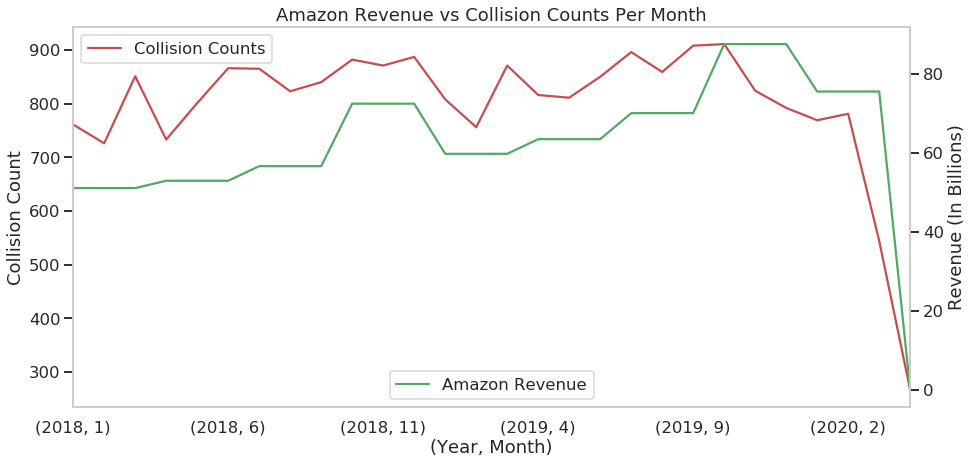

In [46]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_ylabel('Collision Count')
new_df.groupby(['year','month']).charge_desc.size().plot(ax=ax, label='Collision Counts', color='r')
ax.set_xlabel('(Year, Month)')
ax.set_title('Amazon Revenue vs Collision Counts Per Month')
ax.grid(False)

ax2 = ax.twinx()
new_df.groupby(['year','month']).revenue.agg(min).plot(ax=ax2, color='g', label='Amazon Revenue')
ax2.set_ylabel('Revenue (In Billions)')
ax2.grid(False)

ax.legend()
ax2.legend(loc='lower center')

This plot shows that both Amazon Revenue and Collision Counts tend to rise and fall similarly. The trends show that both Amazon Revenue and Collision Counts peak around the holiday seasons. This further solidifies our assumption that Amazon Revenue and Collision Counts are positively correlated.

#### Verifying Multivariate Normality

In [47]:
st, p = stats.normaltest(new_df['revenue'].values)
st, p #With alpha value 0.01, we reject the null hypothesis that Amazon revenue is a normal distribution

(5064.603619520098, 0.0)

In [48]:
st, p = stats.normaltest(new_df.groupby(['year','quarter']).charge_desc.size().values)
st, p #With alpha value 0.01, we fail to reject the null hypothesis, collisions count follows a normal distribution

(24.79025924348713, 4.1386967194883885e-06)

In [49]:
st, p = stats.normaltest(new_df.groupby(['year','quarter']).dui_counts.agg(min).values)
st, p #With alpha value 0.01, we fail to reject the null hypothesis, DUI collisions count follows a normal distribution

(2.4653398376090196, 0.29151322110364913)

In [50]:
st, p = stats.normaltest(new_df.groupby(['year','quarter']).amount_rainfall.agg(min).values)
st, p #With alpha value 0.01, we fail to reject the null hypothesis, rainfall follows a normal distribution

(20.395358013676017, 3.7256690935550084e-05)

These four normal tests show that all of our features are normal except for Amazon revenue. This means not all five conditions for linear regression are fulfilled therefore our results from OLS Regression is not the best representation of the relationship between dui_counts, amount_rainfall, revenue with collision_counts.

Now we check for OLS Regression for collision counts against the other variables

In [51]:
outcome_1, predictors_1 = patsy.dmatrices('collision_counts ~ revenue', new_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:       collision_counts   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     5676.
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:04:22   Log-Likelihood:            -1.3001e+05
No. Observations:               22368   AIC:                         2.600e+05
Df Residuals:                   22366   BIC:                         2.600e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    618.7476      2.708    228.455      0.0

The R-squared is 0.202 meaning that there is little variance represented by this model.

Here, we set xs to 1 through 12 for each month. The ys are based on the coefficient and intercepts from the results of OLS regression.

In [52]:
xs = np.arange(1, 13)
ys = 3.0882*xs + 618.7476

The line is not the true best fit because of the outliers. That makes the intercept lower than it should be.

Text(0.5, 1.0, 'Linear Regression of Revenue on Collision Counts')

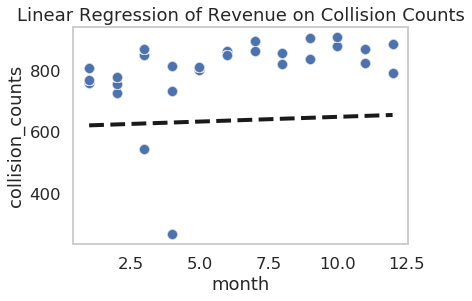

In [53]:
sns.scatterplot(x='month', y='collision_counts', alpha=0.3, data=new_df, s=100)
plt.plot(xs, ys, '--k', linewidth=4, label='Model')
plt.title('Linear Regression of Revenue on Collision Counts')


### Are there other factors that affect the number of collisions?

We plot the number of DUI collisions with non-DUI collisions. This shows to us that DUIs make up a small portion of total collisions.

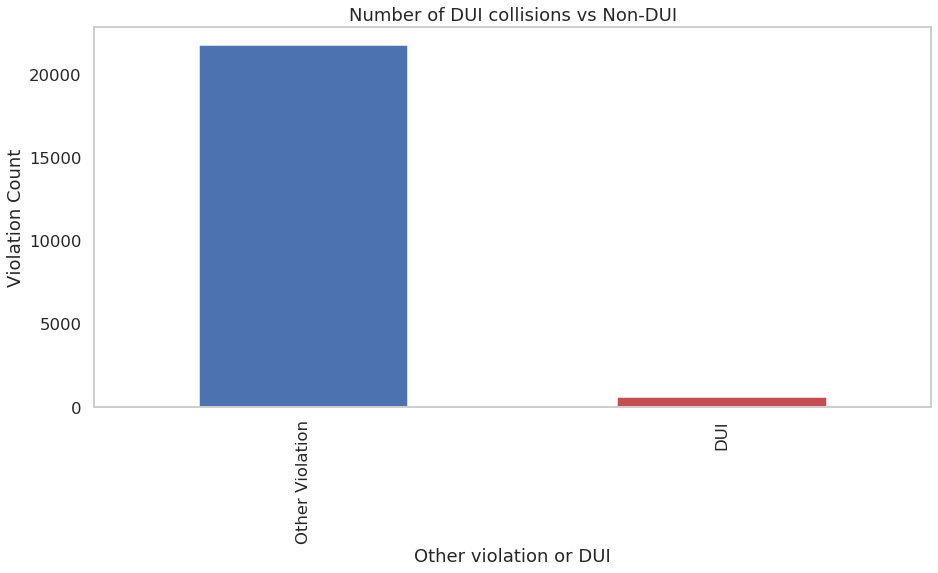

In [54]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_ylabel('Violation Count')
ax.set_xlabel('Other violation or DUI')
ax.set_title('Number of DUI collisions vs Non-DUI')
new_df['charge_desc'].value_counts().plot(kind='bar', color=['b', 'r'], grid=False)

We found out that only about 3% of charge descriptions involved DUIs

In [55]:
number_of_dui = len(new_df[new_df['charge_desc'] == 'DUI'])
total_collisions = len(new_df['charge_desc'])
number_of_dui / total_collisions #Percent of Collisions that are DUI

0.02736051502145923

We graph the number of DUI counts against collision counts based on year and month. This graph shows that they do not share similarities for 2018, but start to resemble similar shapes in the second half of 2019.

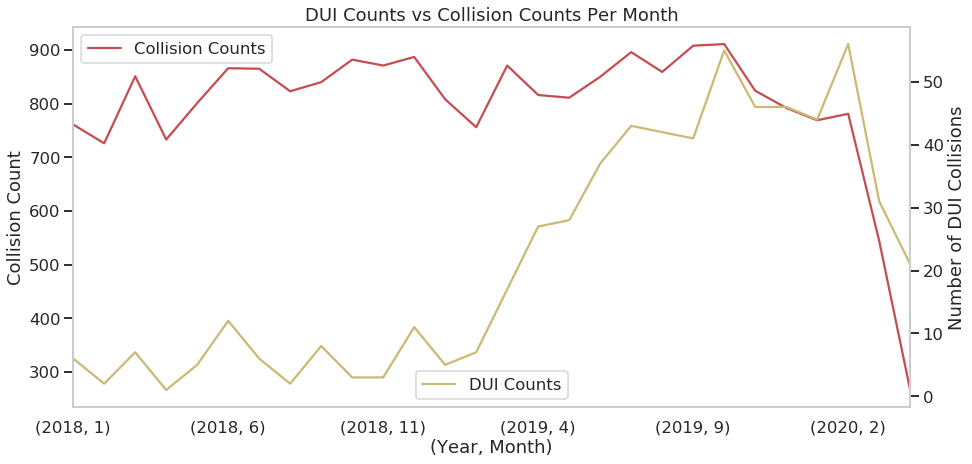

In [56]:
fig3, ax3 = plt.subplots(figsize=(15,7))
ax3.set_ylabel('Collision Count')
new_df.groupby(['year','month']).charge_desc.size().plot(ax=ax3, label='Collision Counts', color='r')
ax3.set_xlabel('(Year, Month)')
ax3.set_title('DUI Counts vs Collision Counts Per Month')
ax3.grid(False)

ax4 = ax3.twinx()
new_df.groupby(['year','month']).dui_counts.agg(min).plot(ax=ax4, label='DUI Counts', color='y')
ax4.set_ylabel('Number of DUI Collisions')
ax4.grid(False)

ax3.legend()
ax4.legend(loc='lower center')

In [57]:
outcome_1, predictors_1 = patsy.dmatrices('collision_counts ~ dui_counts', new_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:       collision_counts   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     165.6
Date:                Sun, 07 Jun 2020   Prob (F-statistic):           9.34e-38
Time:                        13:04:25   Log-Likelihood:            -1.3245e+05
No. Observations:               22368   AIC:                         2.649e+05
Df Residuals:                   22366   BIC:                         2.649e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    809.4957      0.935    866.198      0.0

R-squared is 0.007 meaning there is very little variance represented by this model.

In [58]:
xs = np.arange(1, 13)
ys = 0.4172*xs + 809.4957

The lineplot confirms there is little variance by showing a line that fits well with the scattered points.

Text(0.5, 1.0, 'Linear Regression of DUI on Collision Counts')

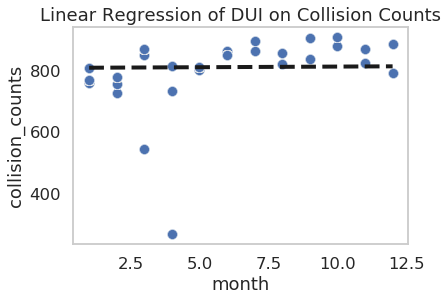

In [59]:
sns.scatterplot(x='month', y='collision_counts', alpha=0.3, data=new_df, s=100)
plt.plot(xs, ys, '--k', linewidth=4, label='Model')
plt.title('Linear Regression of DUI on Collision Counts')


### Collision Counts and Rainfall (In Inches) Plot

We graph rainfall against collision counts based on year and month. This graph shows that there is little to no similarities between the two.

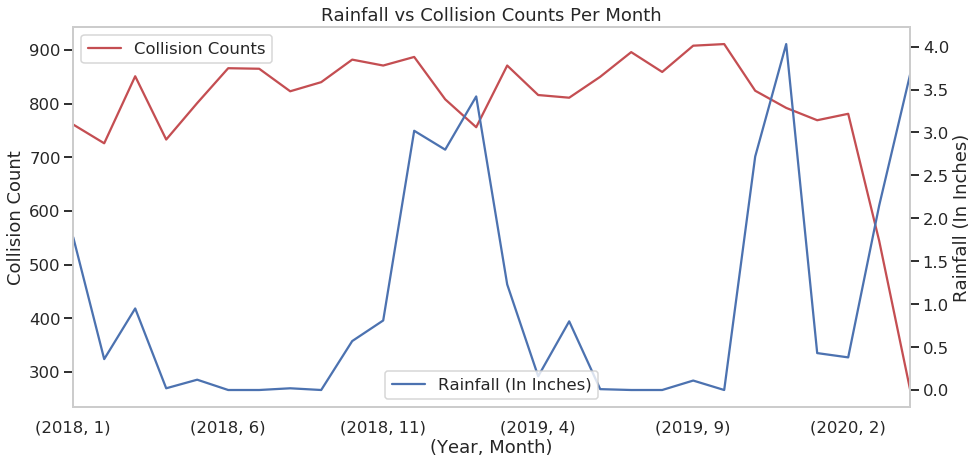

In [60]:
fig5, ax5 = plt.subplots(figsize=(15,7))
ax5.set_ylabel('Collision Count')
new_df.groupby(['year','month']).charge_desc.size().plot(ax=ax5, label='Collision Counts', color='r')
ax5.set_xlabel('(Year, Month)')
ax5.set_title('Rainfall vs Collision Counts Per Month')
ax5.grid(False)

ax6 = ax5.twinx()
new_df.groupby(['year','month']).amount_rainfall.agg(min).plot(ax=ax6, label='Rainfall (In Inches)', color='b')
ax6.set_ylabel('Rainfall (In Inches)')
ax6.grid(False)

ax5.legend()
ax6.legend(loc='lower center')

In [61]:
outcome_1, predictors_1 = patsy.dmatrices('collision_counts ~ amount_rainfall', new_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:       collision_counts   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     3477.
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:04:27   Log-Likelihood:            -1.3092e+05
No. Observations:               22368   AIC:                         2.618e+05
Df Residuals:                   22366   BIC:                         2.619e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         844.5156      0.714   11

R-squared is 0.135 meaning there is little variance represented by this model.

In [62]:
xs = np.arange(1, 13)
ys = -26.9378*xs + 844.5156

The slope of this graph is inaccurate because the outliers are off by hundreds. Based on assumptions, if we remove the two outliers, the slope should be somewhat positive but the plot shows that its negative.

Text(0.5, 1.0, 'Linear Regression of Rainfall on Collision Counts')

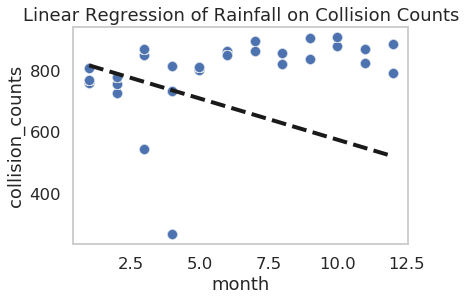

In [63]:
sns.scatterplot(x='month', y='collision_counts', alpha=0.3, data=new_df, s=100)
plt.plot(xs, ys, '--k', linewidth=4, label='Model')
plt.title('Linear Regression of Rainfall on Collision Counts')


Now we check for OLS Regression for collision counts against dui counts, rainfall, and revenue.

In [64]:
outcome_1, predictors_1 = patsy.dmatrices('collision_counts ~ dui_counts + amount_rainfall + revenue', new_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:       collision_counts   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     6997.
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:04:29   Log-Likelihood:            -1.2513e+05
No. Observations:               22368   AIC:                         2.503e+05
Df Residuals:                   22364   BIC:                         2.503e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         553.2584      2.439    2

R-squared is 0.484 meaning that there is some variance represented in this model.

In [65]:
xs = np.arange(1, 13)
ys = 553.2584 + -2.0325*xs + -34.5284*xs + 5.3023*xs

Because of the outliers and larger variance, the slope of this graph is very off.

Text(0.5, 1.0, 'Multivariate Regression on Collision Counts')

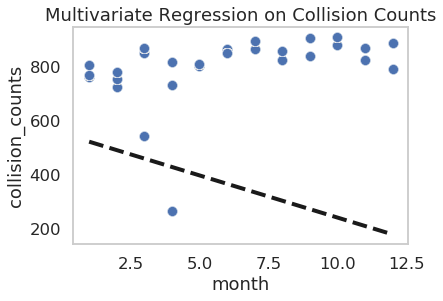

In [66]:
sns.scatterplot(x='month', y='collision_counts', alpha=0.3, data=new_df, s=100)
plt.plot(xs, ys, '--k', linewidth=4, label='Model')
plt.title('Multivariate Regression on Collision Counts')


# Ethics & Privacy

&emsp; All of the datasets we used are free and open to the public, with no additional information on restriction of use. All of the data concerning Amazon sales and car accidents do not contain any Personally Identifiable Information (PII) as we are specifically focusing on the rate of car accidents in a given period, and not necessarily the individual behind the accident. <br>

&emsp; A potential bias in the car accident data is that minor car accidents that do not involve any injuries or fatalities could have not been reported, so it may be more likely that the car accidents reported will be those that have reached a certain degree of severity. Thus, the number of reported car accidents will be less than the number of car accidents that actually occurred. We acknowledge this bias and ensure that our conclusion takes into account that our results are based on our given datasets and don't generalize all accidents. <br>

&emsp; There will be bias in the Amazon revenue dataset because it includes quarterly results, meaning that the monthly intervals will be unknown. We will interpret our analysis differently due to the quarterly format and acknowledge how any missing information could affect our results.<br>

&emsp; Amazon does not publicly release its sales data, therefore we fixed this issue by tracking their quarterly revenue through third party companies. If we can track their quarterly revenue, then we can draw out a trend in their sales and identify any correlations to their sales and the rate of car accidents in San Diego. Our results may make Amazon seem responsible for negative factors, but in no way do we mean to misrepresent them.


# Conclusion & Discussion

&emsp; Based on our analysis, there is a positive correlation between Amazon sales and the number of car accidents within San Diego. However, based on linear regression, collision count is not affected by drunk driving or rainfall. We originally thought these two were strong attributes to the number of car accidents, but the opposite is the case. Graphing collisions against DUI had little resemblance until the latter of the graph, while collisions against rainfall had almost no resemblence at all. Although Amazon revenue and collision counts share very similar patterns, we do not think an increase in Amazon sales causes more car accidents. There is positive correlation between the two because they both change depending on the time of the year. For example, holidays and car collisions tend to be at their highest during major holidays such as Christmas. This shows that this relationship is correlation, not causation. We predicted this would be the case, but are surprised their outcomes are more similar than we thought. <br>

&emsp; Our data analysis was limited by data available from Amazon. Revenue was presented in quarters meaning that we were unable to compare revenue with others by each month. We also wanted to see how many car collisions were from Amazon vehicles or employees, but those datasets are not published to the public. Also, some car accidents in our collisions dataset may have involved DUI, but were not specifically stated in its charge description (i.e. 'misc' or 'etc'). We recognize this but do not think it will be an issue since DUI's only consist of less than 3% of charge descriptions so there will be little to no difference.


# Team Contributions

We tried to contribute equally by having full group pair programming sessions where the driver would share his screen via Discord and the others would provide their code attempts in the chat.

Nathan and Eric were assigned creating the DataFrames and Data cleaning. Jason and Jeffrey were assigned graph construction and Data Analysis.